In [1]:
import pandas as pd
import multiprocessing as mp
import glob
import numpy as np
import matplotlib.pyplot as plt

from skimage.io import imread

from skimage.data import shepp_logan_phantom
from skimage.transform import radon, rescale

import pickle
import os

from PIL import Image, ImageEnhance, ImageFilter

from skimage.transform import iradon
from skimage.transform import iradon_sart

import math

### Single-threaded reading of view measurements from csv

In [ ]:
#DO NOT RUN!!!
cnt=0
strips=[]
csv_paths=sorted(glob.glob("/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose020/out/*.csv"),key=lambda x:int(x[59:-4]))
max_cnt=len(csv_paths)
for csv_path in csv_paths: #Takes lot of time, might not need all of them for experimenting
    if(cnt>3000):
        break
    cnt+=1
    try:
        arr=np.genfromtxt(csv_path,delimiter=',')
        arr=np.exp(arr)
        arr=np.clip(arr,0,255)
        arr=np.uint8(arr)
        im=Image.fromarray(arr)
        strips.append(im)
    except:
        print("ERROR!!")
    

### Multi-threaded reading of view measurements from csv

In [14]:
#Takes approximately 10-15 minutes
cnt=0
csv_paths=sorted(glob.glob("/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose020/out/*.csv"),key=lambda x:int(x[59:-4]))
max_cnt=len(csv_paths)
max_cnt=11000 #SHOULD BE REMOVED WHEN RUN ON ALL VIEWS
with mp.Manager() as manager:    
    strips = mp.Manager().list([None]*max_cnt)
    def set_strip(inp):
        (csv_path, idx)=inp
        try:
            arr=np.genfromtxt(csv_path,delimiter=',')
            arr=np.exp(arr)
            arr=np.clip(arr,0,255)
            arr=np.uint8(arr)
            im=Image.fromarray(arr)
            strips[idx]=im
        except:
            print(f"ERROR at {idx}")

    pool = mp.Pool(mp.cpu_count())
    pool.map(set_strip, zip(csv_paths[:max_cnt],range(max_cnt)))
strips=list(strips)
strips=list(filter(None, strips))

### Create sinogram from views

In [15]:
ANGLES=1440
HALF_ANGLES=ANGLES//2
PROJECTIONS=896
HALF_PROJECTIONS=PROJECTIONS//2
START_PERIOD=2
SMALL_R=518
BIG_R=910
FULL_CIRCLE=2*math.pi
SEMI_CIRCLE=FULL_CIRCLE/2

In [16]:
MAX_DISPLACEMENT=math.sqrt(SMALL_R**2-(BIG_R/2)**2)
HALF_VIEW_ANGLE=math.asin(MAX_DISPLACEMENT/SMALL_R)
VIEW_ANGLE=2*HALF_VIEW_ANGLE

In [17]:
def plot(sinogram):
    plt.figure()
    plt.xlabel('angle (deg)')
    plt.ylabel('projection (pixel)')
    np.arange(0.0, 180.0, step=30.0)
    plt.imshow(sinogram,cmap=plt.cm.Greys_r)

In [18]:
def create_sinogram_stupid(strips):
    sinogram = Image.new('L', (ANGLES,PROJECTIONS))
    for idx in range(START_PERIOD*ANGLES,(START_PERIOD+1)*ANGLES):
        strip=Image.fromarray(np.expand_dims(np.mean(np.array(strips[idx]),axis=0),axis=1))
        i=idx-START_PERIOD*ANGLES
        sinogram.paste(strip, (i, 0))
    plot(sinogram)
    return sinogram

In [19]:
def create_sinogram_stupid_full(strips):
    num=len(strips)
    sinogram = Image.new('L', (PROJECTIONS, num))
    for i in range(num):
        strip=Image.fromarray(np.expand_dims(np.mean(np.array(strips[i]),axis=0),axis=1))
        sinogram.paste(strip, (i, 0))
    plot(sinogram)
    return sinogram

In [20]:
def create_sinogram_intuitive(strips):
    sinogram=Image.new('L',(ANGLES,PROJECTIONS))
    pixels=sinogram.load()
    for idx in range(START_PERIOD*ANGLES,(START_PERIOD+1)*ANGLES):
        strip=np.mean(np.array(strips[idx]),axis=0)
        i=idx-START_PERIOD*ANGLES
        for j in range(PROJECTIONS):
            pixels[(i+j)%ANGLES,j]=int(strip[j])
    plot(sinogram)
    return sinogram

In [21]:
def create_sinogram_intuitive_param(strips,slope):
    sinogram=Image.new('L',(ANGLES,PROJECTIONS))
    pixels=sinogram.load()
    for idx in range(START_PERIOD*ANGLES,(START_PERIOD+1)*ANGLES):
        strip=np.mean(np.array(strips[idx]),axis=0)
        i=idx-START_PERIOD*ANGLES
        for j in range(PROJECTIONS):
            pixels[(int(i+slope*j))%ANGLES,j]=int(strip[j])
    plot(sinogram)
    return sinogram

In [22]:
def my_round(v,maxi):
    return min(maxi-1,round(v))

In [23]:
def create_sinogram_trigonometry(strips):
    
    sinogram=Image.new('L',(ANGLES,PROJECTIONS))#,color=128)
    pixels=sinogram.load()
    central_angles=np.linspace(0,FULL_CIRCLE,ANGLES)
    displacement_angles=np.linspace(0,HALF_VIEW_ANGLE,HALF_PROJECTIONS,endpoint=False)
    displacements=np.sin(displacement_angles)*SMALL_R
    
    
    for idx in range(START_PERIOD*ANGLES,(START_PERIOD+1)*ANGLES):
        
        strip=np.min(np.array(strips[idx]),axis=0)
        i=idx-START_PERIOD*ANGLES
        
        for j in range(HALF_PROJECTIONS):
            angle_rad=(central_angles[i]+displacement_angles[j])%FULL_CIRCLE
            angle_pixel=my_round(ANGLES*angle_rad/FULL_CIRCLE,ANGLES)
            projection_pixel=my_round(HALF_PROJECTIONS+HALF_PROJECTIONS*(displacements[j]/MAX_DISPLACEMENT),PROJECTIONS)
            pixels[angle_pixel,projection_pixel]=int(strip[HALF_PROJECTIONS+j])
        
        for j in range(HALF_PROJECTIONS):
            angle_rad=(central_angles[i]-displacement_angles[j]+FULL_CIRCLE)%FULL_CIRCLE
            angle_pixel=my_round(ANGLES*angle_rad/FULL_CIRCLE,ANGLES)
            projection_pixel=my_round(HALF_PROJECTIONS-HALF_PROJECTIONS*(displacements[j]/MAX_DISPLACEMENT),PROJECTIONS)
            pixels[angle_pixel,projection_pixel]=int(strip[HALF_PROJECTIONS-j])
    
    
    plot(sinogram)
    return sinogram

In [24]:
def create_sinogram_trigonometry2(strips):
    
    sinogram=Image.new('L',(HALF_ANGLES,PROJECTIONS),color=0)
    pixels=sinogram.load()
    central_angles=np.linspace(0,FULL_CIRCLE,ANGLES)
    displacement_angles=np.linspace(0,HALF_VIEW_ANGLE,HALF_PROJECTIONS,endpoint=False)
    displacements=np.sin(displacement_angles)*SMALL_R
    
    
    for idx in range(START_PERIOD*ANGLES,(START_PERIOD+1)*ANGLES):
        
        strip=np.mean(np.array(strips[idx]),axis=0)
        i=idx-START_PERIOD*ANGLES
        
        for j in range(HALF_PROJECTIONS):
            angle_rad=(central_angles[i]+displacement_angles[j])%FULL_CIRCLE
            angle_pixel=my_round(HALF_ANGLES*angle_rad/FULL_CIRCLE,HALF_ANGLES)
            projection_pixel=my_round(HALF_PROJECTIONS+HALF_PROJECTIONS*(displacements[j]/MAX_DISPLACEMENT),PROJECTIONS)
            pixels[angle_pixel,projection_pixel]=int(strip[HALF_PROJECTIONS+j])
        
        for j in range(HALF_PROJECTIONS):
            angle_rad=(central_angles[i]-displacement_angles[j]+FULL_CIRCLE)%FULL_CIRCLE
            angle_pixel=my_round(HALF_ANGLES*angle_rad/FULL_CIRCLE,HALF_ANGLES)
            projection_pixel=my_round(HALF_PROJECTIONS-HALF_PROJECTIONS*(displacements[j]/MAX_DISPLACEMENT),PROJECTIONS)
            pixels[angle_pixel,projection_pixel]=int(strip[HALF_PROJECTIONS-j])
    plot(sinogram)
    return sinogram

### Comparing methods

In [ ]:
for method in [create_sinogram_stupid, create_sinogram_intuitive, create_sinogram_trigonometry]:
    method(strips)

In [ ]:
sinogram=create_sinogram_trigonometry2(strips)

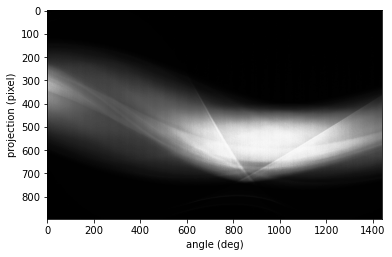

In [25]:
sinogram=create_sinogram_stupid(strips)

In [ ]:
sinogram.resize((720, 896), Image.BICUBIC)

In [ ]:
sinogram.resize((45, 56), Image.BICUBIC)

In [ ]:
sinogram.filter(ImageFilter.GaussianBlur(1))

In [ ]:
sinogram.filter(ImageFilter.SMOOTH_MORE)

In [ ]:
for method in [create_sinogram_stupid,create_sinogram_intuitive,create_sinogram_trigonometry]:
    method(strips)
#sinogram_stupid=create_sinogram_stupid(strips)

In [ ]:
#sinogram.save("/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose020/first_sinogram.jpg")

In [ ]:
sinogram.show()

### Inverse Radon

In [ ]:
sino_arr=np.transpose(np.array(sinogram))
sino_arr.shape

In [26]:
theta = np.linspace(0., 360., 1440, endpoint=False)
reconstruction_fbp = iradon(np.array(sinogram))#, theta=theta, output_size=512)#, circle=True)

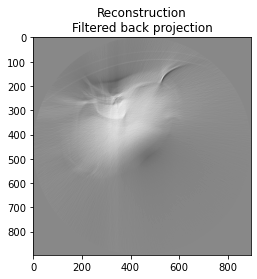

In [27]:
plt.title("Reconstruction\nFiltered back projection")
plt.imshow(reconstruction_fbp, cmap=plt.cm.Greys_r)
plt.show()

In [ ]:
2+3

In [ ]:
sinogram.show()

In [ ]:
np.max(np.array(sinogram))